In [273]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from functools import reduce
import os
import re
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
from scipy.optimize import minimize
from math import floor, ceil
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize = 18)
plt.rc('ytick', labelsize = 18)
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

def spike_conc(x):
    conc = ''
    if 'LE01' in x:
        conc = '0.1 pg'
    elif re.search('LE1$', x):
        conc = '1 pg'
    elif 'LE100' in x:
        conc = '100 pg'
    elif 'LE1K' in x:
        conc = '1000 pg'
    return conc

def published():
    gene_expr = '/stor/work/Lambowitz/cdw2854/EV_polyA/published_expr/rna_tissue.tsv'
    expr_df = pd.read_table(gene_expr) \
        .pipe(pd.pivot_table, columns = 'Sample', 
              index = ['Gene','Gene name'], values = 'Value')\
        .reset_index()
    return expr_df


def read_salmon(filename, column = 'NumReads'):
    samplename = os.path.basename(os.path.dirname(filename))
    assert(column in ['NumReads','TPM'])
    return pd.read_table(filename)\
        .rename(columns = {column:samplename}) \
        .filter(['Name', samplename])

In [64]:
def salmon_df(quant = 'TPM'):
    assert(quant in ['TPM', 'CPM'])
    column = 'NumReads' if quant == 'CPM' else 'TPM'
    salmon_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/salmon_result'
    sample_folders = glob.glob(salmon_path + '/Q*LE*')
    gene_sf = map(lambda x: x + '/quant.genes.sf', sample_folders)
    df = list(map(lambda f: read_salmon(f, column = column), gene_sf))
    df = reduce(lambda x,y: x.merge(y, how = 'outer', on = ['Name']), df)
    return df

In [65]:
cpm_df = salmon_df(quant='CPM')
cpm_df.head()

,Name,Qcf_LE1K,Qcf_LE100,Qcf_LE01,Qcf_LE1
0,ERCC-00171,170.0,221.0,0.0,1.0
1,ERCC-00158,0.0,0.0,0.0,0.0
2,ERCC-00156,0.0,0.0,0.0,0.0
3,ERCC-00150,2.0,1.0,0.0,0.0
4,ERCC-00143,0.0,0.0,0.0,0.0


In [81]:
spike_df = cpm_df\
    .assign(ercc = lambda d: np.where(d.Name.str.contains('ERCC'),
                                       'ERCC',
                                        'Not ERCC')) \
    .pipe(pd.melt, 
          id_vars = ['Name', 'ercc'],
         var_name = 'samplename',
         value_name = 'cpm') \
    .assign(cpm = lambda d: d.groupby('samplename').cpm.transform(lambda x: 1e6*x/x.sum()))\
    .groupby(['samplename','ercc'], as_index=False)\
    .agg({'cpm':'sum'}) \
    .assign(ercc_fraction = lambda d: d.groupby('samplename')['cpm'].transform(lambda x: x/x.sum()))  \
    .query('ercc == "ERCC"') \
    .assign(conc_label = lambda d: d.samplename.map(spike_conc)) \
    .assign(conc = lambda d: d.conc_label.str.replace(' pg','').astype(float)) \
    .assign(log_cpm = lambda d: np.log10(d.cpm+1))\
    .assign(log_conc = lambda d: np.log10(d.conc)) \
    .assign(mRNA_conc = lambda d: d.conc/d.ercc_fraction - d.conc ) \
    .assign(log_mRNA = lambda d: np.log10(d.mRNA_conc)) \
    .assign(log_mRNA_cpm = lambda d: np.log10((1-d.ercc_fraction) * 1e6))
spike_df

,samplename,ercc,cpm,ercc_fraction,conc_label,conc,log_cpm,log_conc,mRNA_conc,log_mRNA,log_mRNA_cpm
0,Qcf_LE01,ERCC,113.120031,0.000113,0.1 pg,0.1,2.057362,-1.0,883.916734,2.946411,5.999951
2,Qcf_LE1,ERCC,1015.545986,0.001016,1 pg,1.0,3.007127,0.0,983.691992,2.992859,5.999559
4,Qcf_LE100,ERCC,151688.468149,0.151688,100 pg,100.0,5.180955,2.0,559.245895,2.747603,5.928555
6,Qcf_LE1K,ERCC,409206.086859,0.409206,1000 pg,1000.0,5.611943,3.0,1443.756415,3.159494,5.771436


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


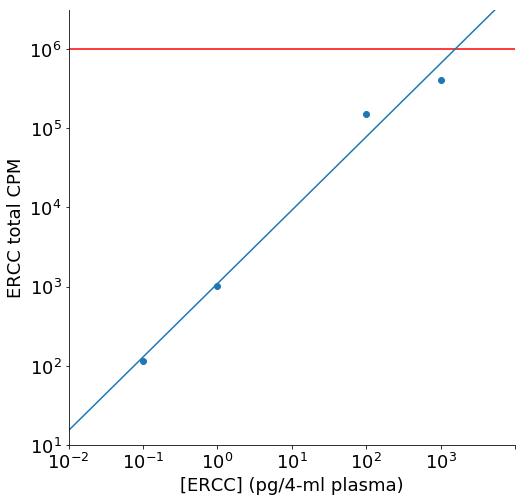

In [274]:
lm = LinearRegression()
X = spike_df.log_conc.values.reshape(-1,1)
Y = spike_df.log_cpm
lm.fit(X, Y)

xmin, xmax = -2,4
ymin, ymax = 1,6.5

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(X, Y)
xs = np.arange(-5,5).reshape(-1,1)
ax.plot(xs, lm.predict(xs))
ax.hlines(y = 6, xmin=-10, xmax = 10, color='red')
ax.set_xlabel(r'[ERCC] (pg/4-ml plasma)')
ax.set_ylabel('ERCC total CPM')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
sns.despine()

xs = np.arange(xmin, xmax)
xs = [r'$10^{%i}$' %(x) for x in xs]
xs = ax.set_xticklabels(xs)

ys = np.arange(ymin, ymax)
ys = [r'$10^{%i}$' %(y) for y in ys]
ys = ax.set_yticklabels(ys)

$\pi_{ercc} = \frac{m_e}{m_e+m_m}$

$ (1-\pi_{ercc} )(m_e) = \pi_{ercc} m_m $

Take $log$ and add a error term ($\epsilon$) for optimization:

$ log(1-\pi_{ercc}) + log(m_e) = log(\pi_{ercc}) + log(m_m) + \epsilon$

$ \epsilon(m_m) = log(1-\pi_{ercc}) + log(m_e) - log(\pi_{ercc}) - log(m_m) $

$ L(m_m) = MSE(m_m) = \sum_{i\in(0.1,1,100,1000)} \epsilon(i; m_m)   $

where $\pi_{ercc}$ is the fraction ERCC read count, $m_e$ is the amount (pg/4-ml plasma) of ERCC spike-ins and $m_m$ is the amount (pg/4-ml plasma) of mRNA

In [228]:
def loss_function(m_m, spike_df):
    y = np.log(1 - spike_df.ercc_fraction) + np.log(spike_df.conc)
    x = np.log(spike_df.ercc_fraction) + np.log(m_m)
    return mean_squared_error(y, x)

_min = minimize(loss_function, x0 = 900, args=(spike_df))

In [280]:
def plot_error(ax, spike_df, _min):
    xs = np.arange(800, 1000)
    err = np.array([loss_function(x, spike_df) for x in xs])
    ax.plot(xs, err)
    ax.set_ylabel(r'$L(m_m)$')
    ax.set_xlabel('$m_m$; [polyA-RNA] (pg/4-ml plasma)')
    ax.vlines(x = _min.x[0], ymin = 0, ymax=err.max(), color = 'red')
    ax.text(_min.x[0] * 0.97, err.max() * 1.01, 
        '[mRNA] = %.1f ' %_min.x[0], fontsize = 15,
       color = 'red')
    ax.set_ylim(err.min() * 0.99, err.max() * 1.07)
    
def plot_regression(ax, spike_df, _min):
    y = np.log(1 - spike_df.ercc_fraction) + np.log(spike_df.conc)
    ax.scatter(np.log(spike_df.ercc_fraction),y)
    ax.plot(y - np.log(_min.x[0]), y, color = 'black')
    ax.set_xlabel('$log(\pi_{ercc})$')
    ax.set_ylabel('$log(1-\pi_{ercc}) + log(m_e)$')
    ax.text(-5, 0, r'y = x + log(%.1f)' %_min.x[0], fontsize = 15)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


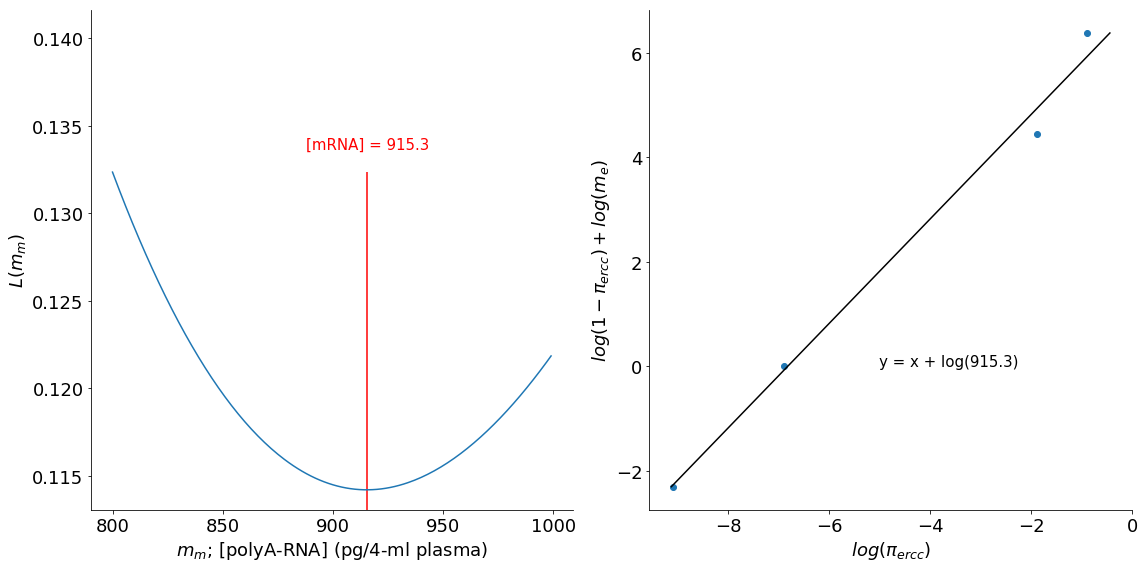

In [281]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plot_error(ax, spike_df, _min)
plot_regression(ax2, spike_df, _min)
sns.despine()
fig.tight_layout()

In [75]:
log10_conc = (np.log10(1e6) - lm.intercept_ )/lm.coef_[0][0] 
conc = 10**(log10_conc)
print(log10_conc, conc)

3.34123848917 2194.00942649


$ log_10(E_cpm) = 0.93 (log_{10})(m_E) + 3.04 $

where $ E_{cpm} = \frac{E_{count}}{10^6}$, true abundance $ m_E = \frac{m_E}{m_E + m_m} $

Amount of poly-A RNA in plasma ([mRNA]) can be derived by setting $TPM$ as $10^6$:

$ log_{10} 10^6  = 0.93(log_{10}[mRNA])+ 3.04$, where [mRNA] is measured in pg/4 ml plasma

$ log_{10}[mRNA] = 3.192 $

$ [mRNA] = 1559.1 $

Hence, from 4-ml of plasma, we would get 1.56 ng poly-A mRNA

In [70]:
ercc_df = pd.read_table('/stor/work/Lambowitz/ref/RNASeqConsortium/ercc/ercc_table.tsv') \
    .filter(regex='id|mix1') \
    .rename(columns = {'id':'Name'}) \
    .merge(salmon_df(quant = 'TPM'), how ='inner') \
    .pipe(pd.melt, id_vars = ['Name','mix1'],
         var_name = 'samplename',
         value_name = 'tpm') \
    .assign(label = lambda d: d.samplename.map(spike_conc).str.replace(' pg','').astype(float)) \
    .assign(log_tpm = lambda d: np.log2(d.tpm + 1))\
    .assign(log_conc = lambda d: np.log2(d.mix1))
ercc_df.head()

,Name,mix1,samplename,tpm,label,log_tpm,log_conc
0,ERCC-00130,30000.00,Qcf_LE1K,37405.600,1000.0,15.191005,14.872675
1,ERCC-00004,7500.00,Qcf_LE1K,29012.600,1000.0,14.824442,12.872675
2,ERCC-00136,1875.00,Qcf_LE1K,4958.480,1000.0,12.275973,10.872675
3,ERCC-00108,937.50,Qcf_LE1K,2022.170,1000.0,10.982402,9.872675
4,ERCC-00116,468.75,Qcf_LE1K,180.803,1000.0,7.506232,8.872675


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


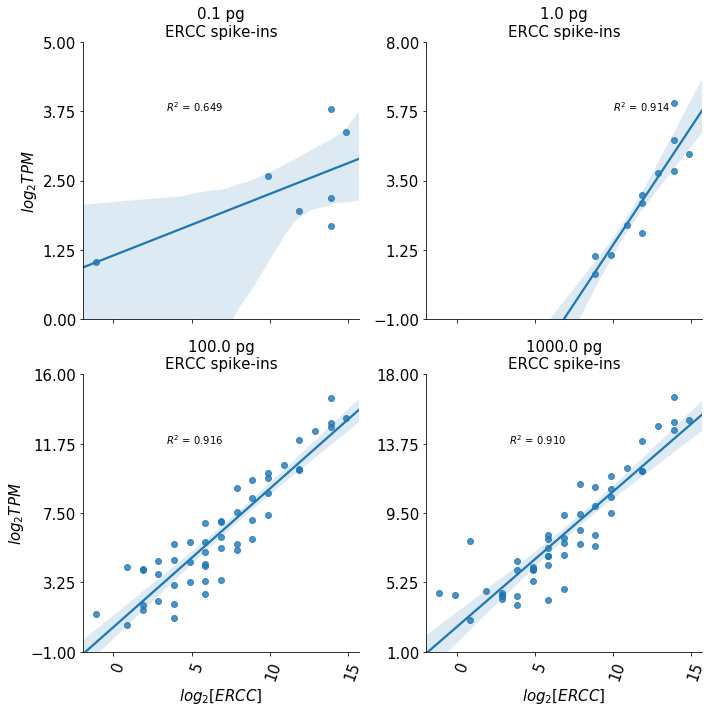

In [71]:
p = sns.FacetGrid(data = ercc_df\
                      .sort_values('label')\
                      .query('tpm>0'),
                 col = 'label',
                 col_wrap = 2,
#                 sharex = False,
                 sharey = False,
                 size = 5)
p.map(sns.regplot, 'log_conc','log_tpm', ci = 90)
p.set_axis_labels(r'$log_{2}[ERCC]$',
                  r'$log_2 TPM$')
p.set_titles('{col_name} pg\nERCC spike-ins')

for ax in p.fig.axes:
    sub_df = ercc_df\
        .query('label == "%s"' %ax.get_title().split(' ')[0])\
        .query('tpm > 0')
 
    
    ys = np.linspace(floor(sub_df.log_tpm.min()) - 1,
                ceil(sub_df.log_tpm.max()) + 1, 5)
    
    xs = np.linspace(floor(sub_df.log_conc.min()) - 1,
                ceil(sub_df.log_conc.max()) + 1, 4)
    
    pr, pval = pearsonr(sub_df.log_tpm, sub_df.log_conc)
    ax.text(xs[1], ys[-2], '$R^2$ = %.3f' %(pr))
    
#    ax.set_xlim(xs.min(), xs.max())
    ax.set_ylim(ys.min(), ys.max())
    
    ax.set_yticks(ys)
#    ax.set_xticks(xs)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, 
                       ha = 'right', rotation_mode="anchor")
    
p.fig.tight_layout()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


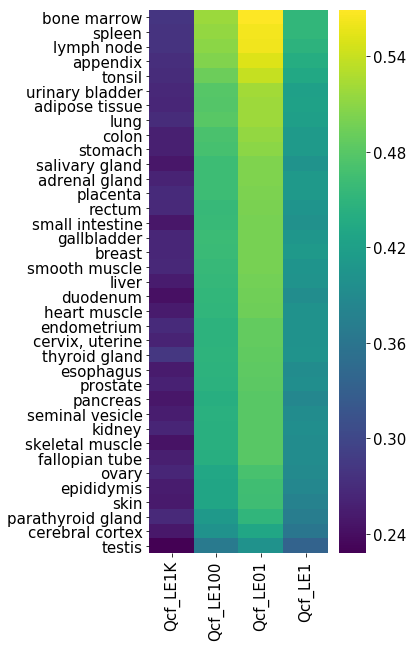

In [73]:
cor_df = salmon_df(quant = 'TPM') \
    .pipe(lambda d: d[~d.Name.str.contains('ERCC')]) \
    .assign(Gene = lambda d: d.Name.str.split('.', expand=True).iloc[:,0]) \
    .drop('Name', axis=1)\
    .merge(published(), on ='Gene') \
    .drop('Gene', axis=1)\
    .set_index('Gene name')\
    .corr(method='spearman') \
    .filter(regex='Q[cC][fF]') \
    .sort_values('Qcf_LE01', ascending=False)\
    .pipe(lambda d: d[~d.index.str.contains('Q')])

fig = plt.figure(figsize=(4,10))
ax = fig.add_subplot(111)
sns.heatmap(cor_df, cmap='viridis', ax = ax)
ax.set_yticks(np.arange(cor_df.shape[0]) + 0.5)
yts = ax.set_yticklabels(cor_df.index)